In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os.path
from scipy.spatial.distance import cdist
import time
from tqdm import tqdm
%load_ext autoreload
%autoreload 1
#%aimport __pycache__.lddt.cpython-39
%aimport sautils.encoder_commons
%aimport sautils.common
%aimport torch
import pandas as pd
import numba
from skopt import dump, load
import xmlrpc.client as xmlrpclib
cmd = xmlrpclib.ServerProxy(f'http://localhost:9123')

#conda activate pymol_comp
#export LD_PRELOAD=/usr/lib/x86_64-linux-gnu/libstdc++.so.6
#pymol -R

In [5]:
def show_aln(pdb_dir, aln, color_aln=False, read_alignment=True):
    qname = aln['query']
    tname = aln['target']
    qstart = aln['qstart']
    tstart = aln['tstart']
    cmd.do('import psico; psico.init()')

    if read_alignment:
        qaln = aln['qaln']
        taln = aln['taln']                
        with open('/tmp/align.txt', 'w') as file:    
            file.write('>\n')
            file.write((qstart-1) * 'X' + (tstart-1) * '-' + qaln + '\n')
            file.write('>\n')
            file.write((qstart-1) * '-' + (tstart-1) * 'X' + taln + '\n')

    cmd.reinitialize()
    cmd.do('set mouse_selection_mode, 6')

    cmd.load(pdb_dir + qname + '.ent')
    cmd.load(pdb_dir + tname + '.ent')        
    cmd.do('set seq_view, 1')
    #cmd.do(f"super {tname}, {qname}")
    if read_alignment:
        cmd.do(f"tmalign {qname}, {tname}, object=aln, args=-I /tmp/align.txt")
    else:
        cmd.do(f"tmalign {qname}, {tname}, object=aln")
    cmd.zoom(qname)

    if color_aln:
        if isinstance(color_aln, tuple):
            color_q = color_aln[0]
            color_t = color_aln[1]
        else:
            color_q = color_aln
            color_t = color_aln
        for (tname, j), (qname, i) in cmd.get_raw_alignment('aln'):
            cmd.color(color_q, f'model {qname} and index {i}')
            cmd.color(color_t, f'model {tname} and index {j}')

In [6]:
def prep_pymol(P):
    i = P.shape[0]-1
    j = P.shape[1]-1

    current_aligned_seq1 = ''
    current_aligned_seq2 = ''
    aligned_seq1 = ''
    aligned_seq2 = ''
    while i != -1 and j != -1:
        if P[i,j] == 1:
            current_aligned_seq1 = 'X' 
            current_aligned_seq2 = 'X'
            i = i - 1
            j = j - 1

        elif np.any(P[i,:j]):
            current_aligned_seq1 = 'X'
            current_aligned_seq2 = '-'
            j = j - 1    

        elif np.any(P[:i, j]):
            current_aligned_seq1 = '-'
            current_aligned_seq2 = 'X'
            i = i - 1
        else:
            current_aligned_seq1 = '-x' 
            current_aligned_seq2 = 'x-'
            i = i - 1
            j = j - 1
        aligned_seq1 = aligned_seq1 + current_aligned_seq1
        aligned_seq2 = aligned_seq2 + current_aligned_seq2

    while i != -1:
        aligned_seq1 += '-'
        aligned_seq2 += 'X'
        i -=1
    while j != -1:
        aligned_seq1 += 'X'
        aligned_seq2 += '-'
        j -=1

        # Reversing the order of the sequences
    aligned_seq1 = aligned_seq1[::-1]
    aligned_seq2 = aligned_seq2[::-1]
    
    return aligned_seq1, aligned_seq2
    

In [7]:
sid2seq_ss = {}
with open('data/ss.fasta') as file:
    sid = ''
    for line in file:
        line = line.lstrip('>').rstrip('\n')
        if not sid:
            sid = line
        else:
            sid2seq_ss[sid] = line.upper()
            sid = ''
sid2seq_aa = {}
with open('data/aa.fasta') as file:
    sid = ''
    for line in file:
        line = line.lstrip('>').rstrip('\n')
        if not sid:
            sid = line
        else:
            sid2seq_aa[sid] = line.upper()
            sid = ''
mat3di = np.load('data/mat3di.npy') * 2.1
blosum = np.load('data/blosum62.npy') * 1.4
with open('data/mat3di.out') as f:
    lines = f.readlines()
i2a = lines[3].split()
def seq2num(q):
    idx = []
    for a in q:
        idx.append(i2a.index(a))
    return np.array(idx)
    
def calcS_np(ss1,ss2 ,aa1, aa2,mat3di, blosum):
    ss1 = seq2num(ss1)
    ss2 = seq2num(ss2)
    aa1 = seq2num(aa1)
    aa2 = seq2num(aa2)
    comb_array_ss = np.array(np.meshgrid(ss1, ss2)).T.reshape(-1, 2)
    comb_array_aa = np.array(np.meshgrid(aa1, aa2)).T.reshape(-1, 2)
    S = (mat3di[comb_array_ss[:,0],comb_array_ss[:,1]].reshape(len(ss1),-1)) + blosum[comb_array_aa[:,0],comb_array_aa[:,1]].reshape(len(aa1),-1)
    return S
def distances(q_points_aln, t_points_aln):
    d_mat = cdist(q_points_aln, t_points_aln)
    return (d_mat)

In [8]:
coord_dir = 'data/pdb/d*'
if not os.path.exists(coord_dir):
    print('Creating cache first.')
    sautils.encoder_commons.init_coords('data/pdb/d*', coord_dir)
sid2coords = {sid: sautils.encoder_commons.read_coords(coord_dir, sid) for sid in sautils.encoder_commons.list_sids(coord_dir)}

In [9]:
@numba.jit(nopython=True)
def fill_dp_matrix(scores, gap_open, gap_extend):
    l1, l2 = scores.shape
    s, q_gap, t_gap = np.zeros((l1+1, l2+1)), np.zeros((l1+1, l2+1)), np.zeros((l1+1, l2+1))
    for i in range(1, l1+1):
        for j in range(1, l2+1):
            q_gap[i, j] = max(q_gap[i, j-1] - gap_extend, s[i, j-1] - gap_open)
            t_gap[i, j] = max(t_gap[i-1, j] - gap_extend, s[i-1, j] - gap_open)
            s[i, j] = max(0,
                          q_gap[i, j],
                          t_gap[i, j],
                          s[i-1, j-1] + scores[i-1, j-1])
    return s, q_gap, t_gap

def backtrace_alignment(scores, gap_open, gap_extend, s, q_gap, t_gap):
    S_MAT, QGAP_MAT, TGAP_MAT = 0, 1, 2
    arg_max = np.where(s == s.max())
    i, j, pos = arg_max[0][0], arg_max[1][0], S_MAT
    backtrace = []
    while (s[i, j] > 0 or pos != S_MAT) and (i > 0 and j > 0):
        if pos == S_MAT:
            if s[i, j] == q_gap[i, j]:
                if q_gap[i,j] == q_gap[i, j-1] - gap_extend:
                    pos = QGAP_MAT
                j = j - 1       
            elif s[i, j] == t_gap[i, j]:
                if t_gap[i,j] == t_gap[i-1, j] - gap_extend:
                    pos = TGAP_MAT
                i = i - 1
            elif s[i,j] == s[i-1, j-1] + scores[i-1, j-1]:
                backtrace.append((i,j))
                i, j = i - 1, j - 1                
            else:
                break        
        elif pos == QGAP_MAT:
            if q_gap[i, j] == s[i, j-1] - gap_open:
                pos = S_MAT
            j = j - 1
            
        elif pos == TGAP_MAT:
            if t_gap[i, j] == s[i-1, j] - gap_open:
                pos = S_MAT
            i = i - 1
    return list(reversed([(i-1, j-1) for i, j in backtrace]))

def sw_align(scores, gap_open=30, gap_extend=10):    
    s, q_gap, t_gap = fill_dp_matrix(scores, gap_open, gap_extend)
    backtrace = backtrace_alignment(scores, gap_open, gap_extend, s, q_gap, t_gap)
    return backtrace, (s, q_gap, t_gap)

def format_aln(seq1, seq2, bt):
    s1, s2 = '', ''
    i_prev, j_prev = None, None
    for i, j in bt:        
        if i_prev is not None:
            s1 += seq1[i_prev+1:i] + '-' * len(seq2[j_prev+1:j])
            s2 += '-' * len(seq1[i_prev+1:i]) + seq2[j_prev+1:j]                
        s1 += seq1[i]
        s2 += seq2[j]
        i_prev, j_prev = i, j
    return s1, s2

In [10]:
def fb_local(S, go, ge, T, pre):
    S_exp = np.exp(S/T, dtype = pre)
    S_hat = S_exp[::-1,::-1]

    vj = np.exp(np.linspace((S.shape[1]-1)*ge + go, go, S.shape[1], dtype = pre)/T, dtype = pre)
    wj = np.exp(np.linspace((S.shape[1]-1)*ge , 0, S.shape[1], dtype = pre) /T, dtype = pre)
    #vj = np.exp(np.arange((S.shape[1]-1)*ge + go ,go-ge, -ge, dtype = pre)/T)
    #wj = np.exp((np.arange((S.shape[1]-1)*ge , -ge, -ge, dtype = pre)) /T)
    zm, ze, zf = forward_backward_plain_local(S_exp, vj, wj, T, go, ge, pre)
    zm_hat, ze_hat, zf_hat = forward_backward_plain_local(S_hat, vj, wj, T, go, ge, pre)

    P = ((zm*(zm_hat[::-1,::-1]))/(1 + np.sum(zm))) * np.exp(-S/T, dtype = pre)
    
    return P
    
def fb_global(S, go, ge, T, pre):
    S_exp = np.exp(S/T, dtype = pre)
    S_hat = S_exp[::-1,::-1]

    vj = np.exp(np.linspace((S.shape[1]-1)*ge + go, go, S.shape[1])/T, dtype = pre)
    wj = np.exp(np.linspace((S.shape[1]-1)*ge , 0, S.shape[1]) /T, dtype = pre)
    zm, ze, zf = forward_backward_plain_global(S_exp, vj, wj, T, go, ge, pre)
    zm_hat, ze_hat, zf_hat = forward_backward_plain_global(S_hat, vj, wj, T, go, ge, pre)

    P = (zm*(zm_hat[::-1,::-1]))/ (zm[-1,-1]+ze[-1,-1] +zf[-1,-1]) * np.exp(-S/T, dtype = pre)
    
    return P
def fb_local_global(S, go, ge, T, pre):
    S_exp = np.exp(S/T, dtype = pre)
    S_hat = S_exp[::-1,::-1]

    vj = np.exp(np.linspace((S.shape[1]-1)*ge + go, go, S.shape[1])/T, dtype = pre)
    wj = np.exp(np.linspace((S.shape[1]-1)*ge , 0, S.shape[1]) /T, dtype = pre)
    zm, ze, zf = forward_backward_plain_local(S_exp, vj, wj, T, go, ge, pre)
    zm_hat, ze_hat, zf_hat = forward_backward_plain_global(S_hat, vj, wj, T, go, ge, pre)

    P = (zm*(zm_hat[::-1,::-1]))/ (zm[-1,-1]+ze[-1,-1] +zf[-1,-1])* np.exp(-S/T, dtype = pre)
    
    return P
    
def fb_global_local(S, go, ge, T, pre):
    S_exp = np.exp(S/T, dtype = pre)
    S_hat = S_exp[::-1,::-1]

    vj = np.exp(np.linspace((S.shape[1]-1)*ge + go, go, S.shape[1])/T, dtype = pre)
    wj = np.exp(np.linspace((S.shape[1]-1)*ge , 0, S.shape[1]) /T, dtype = pre)
    zm, ze, zf = forward_backward_plain_global(S_exp, vj, wj, T, go, ge, pre)
    zm_hat, ze_hat, zf_hat = forward_backward_plain_local(S_hat, vj, wj, T, go, ge, pre)

    P = (zm*(zm_hat[::-1,::-1]))/ np.sum(zm) * np.exp(-S/T)
    
    return P

In [11]:
def forward_backward_plain_local(S, vj, wj, T, go, ge, pre):
    exp_go = np.exp(go/T)
    exp_ge = np.exp(ge/T)
    zm = np.zeros((S.shape[0]+1, S.shape[1]+1), dtype = pre)
    ze = np.zeros((S.shape[0]+1, S.shape[1]+1), dtype = pre)
    zf = np.zeros((S.shape[0]+1, S.shape[1]+1), dtype = pre)
    
    #This is the main part where we calculate the Z matrices with one for loop over each row
    for i in range(1,S.shape[0]+1):
        zm[i,1:] = ((zm[i-1,:-1] + ze[i-1,:-1] + zf[i-1,:-1] + 1) *S[i-1,:])
        # this is the new part where ze is calculated using cumsum 
        ze[i,1:] = (np.cumsum(zm[i,:-1] * vj)/wj) 
        zf[i,1:] = (zm[i-1,1:] * exp_go + zf[i-1,1:] * exp_ge)
    #at the end we only need to return zm but for testing i returned all
    return zm[1:,1:], ze[1:,1:], zf[1:,1:]

def forward_backward_plain_global(S, vj, wj, T, go, ge, pre):
    exp_go = np.exp(go/T)
    exp_ge = np.exp(ge/T)
    zm = np.zeros((S.shape[0]+1, S.shape[1]+1), dtype = pre)
    ze = np.zeros((S.shape[0]+1, S.shape[1]+1), dtype = pre)
    zf = np.zeros((S.shape[0]+1, S.shape[1]+1), dtype = pre)
    
    zm[0,0] = 1
    ze[0,1:] = np.exp(np.linspace(go,go+(ge*(S.shape[1]-1)),S.shape[1])/T, dtype = pre)

    #exp_ge_arr = np.exp((np.arange(ge, (S.shape[1] + 1)* ge ,ge,dtype = pre))/T, dtype = pre)
                        
    for i in range(1,S.shape[0]+1):
        zm[i,1:] = (zm[i-1, :-1] + ze[i-1,:-1] + zf[i-1,:-1]) * S[i-1,:]
        ze[i,1:] = (np.cumsum(zm[i,:-1] * vj)/wj) #+  * exp_ge_arr
        zf[i,:] = zm[i-1,:] * exp_go + zf[i-1,:] * exp_ge
    return zm[1:,1:], ze[1:,1:], zf[1:,1:]

In [12]:
def forward_backward_plain_local(S, vj, wj, T, go, ge, pre):
    exp_go = np.exp(go/T)
    exp_ge = np.exp(ge/T)
    zm = np.zeros((S.shape[0]+1, S.shape[1]+1), dtype = pre)
    ze = np.zeros((S.shape[0]+1, S.shape[1]+1), dtype = pre)
    zf = np.zeros((S.shape[0]+1, S.shape[1]+1), dtype = pre)
    
    #This is the main part where we calculate the Z matrices with one for loop over each row
    for i in range(1,S.shape[0]+1):
        zm[i,1:] = ((zm[i-1,:-1] + ze[i-1,:-1] + zf[i-1,:-1] + 1) *S[i-1,:])
        # this is the new part where ze is calculated using cumsum 
        ze[i,1:] = (np.cumsum(zm[i,:-1] * vj)/wj) 
        zf[i,1:] = (zm[i-1,1:] * exp_go + zf[i-1,1:] * exp_ge)
    #at the end we only need to return zm but for testing i returned all
    return zm[1:,1:], ze[1:,1:], zf[1:,1:]
def fb_local(S, go, ge, T, pre):
    S_exp = np.exp(S/T, dtype = pre)
    S_hat = S_exp[::-1,::-1]

    vj = np.exp(np.linspace((S.shape[1]-1)*ge + go, go, S.shape[1], dtype = pre)/T, dtype = pre)
    wj = np.exp(np.linspace((S.shape[1]-1)*ge , 0, S.shape[1], dtype = pre) /T, dtype = pre)
    #vj = np.exp(np.arange((S.shape[1]-1)*ge + go ,go-ge, -ge, dtype = pre)/T)
    #wj = np.exp((np.arange((S.shape[1]-1)*ge , -ge, -ge, dtype = pre)) /T)
    zm, ze, zf = forward_backward_plain_local(S_exp, vj, wj, T, go, ge, pre)
    zm_hat, ze_hat, zf_hat = forward_backward_plain_local(S_hat, vj, wj, T, go, ge, pre)

    P = ((zm*(zm_hat[::-1,::-1]))/(1 + np.sum(zm))) * np.exp(-S/T, dtype = pre)
    
    return P

In [13]:
@numba.njit
def lol_score_approx(d_ij, d_kl, d_seq):
    seq_distance_feat = np.sign(d_seq) * np.log(1 + np.abs(d_seq))
    x = np.empty((d_ij.shape[0],2))
    x[:,0] = seq_distance_feat#[:, None]
    x[:,1] = np.abs(d_ij-d_kl)#[:, None]
    #x = np.hstack([seq_distance_feat[:, None], np.abs(d_ij-d_kl)[:, None],])

    w1 = np.array([[-1.3584513e-04,  9.9329501e-01],
                   [ 7.6149112e-01,  5.7029408e-01],
                   [-8.1348085e-01,  6.0702705e-01]])
    b1 = np.array([0.7043129 , 0.374659  , 0.39905924])
    w2 = np.array([[-0.776632  ,  0.61055756,  0.5823986 ]])
    b2 = np.array([-0.11200039])

    hidden_layer = ((x @ w1.T) + b1)
    hidden_layer *= (hidden_layer > 0)  # if w1 is all positive, we dont need this ReLU
    score = (hidden_layer @ w2.T) + b2
    return score

In [14]:
def calc_startAnchors(S, fb_go, fb_ge, temp, le):
    start_anchors = []
    for i in range(10):
        P = fb_local(S, fb_go, fb_ge, temp, np.longdouble)
        x,y = np.unravel_index(np.argmax(P), P.shape)
        x,y = np.max([0,x-le]), np.max([0,y-le])
        #P -= np.max([0 ,np.max(P)-shift])
        bt, (s, q_gap, t_gap) = sw_align(np.array(P[x:x+(le*2),y:y+(le*2)], dtype = np.double), gap_open = 0, gap_extend=0)
        bt = np.array(bt)
        bt[:,0] += x
        bt[:,1] += y
        start_anchors.append(np.copy(bt))
        S[bt[:,0], bt[:,1]] = - 100
    return start_anchors

In [15]:
def get_gaps(A_all):
    lowerBounds_i = (A_all[:,0]+1)[:-1]
    upperBounds_i = (A_all[:,0]-1)[1:]
    lowerBounds_k = (A_all[:,1]+1)[:-1]
    upperBounds_k = (A_all[:,1]-1)[1:]
    mask_i = lowerBounds_i<=upperBounds_i
    mask_k = lowerBounds_k<=upperBounds_k
    mask = np.logical_and(mask_i,  mask_k)
    return np.array([np.sort(np.array([lowerBounds_i[mask],upperBounds_i[mask]+1]).reshape(-1)),
                    np.sort(np.array([lowerBounds_k[mask],upperBounds_k[mask]+1]).reshape(-1))])

In [16]:
def lol_matrix_gap_dist_aprox(A, All_a, gaps,d_mat_ij, d_mat_kl):

    ti, tk, tidx = lol_matrix_prep_gaps(A, All_a, gaps, d_mat_ij, d_mat_kl)
    idx = np.logical_and(ti > 0, tk > 0)
    G_mat = np.zeros_like(ti)
    G_mat[idx] += np.squeeze(np.nan_to_num(lol_score_approx(ti[idx], tk[idx], tidx[idx])))
    return G_mat.reshape(gaps[0,1]-gaps[0,0], gaps[1,1]-gaps[1,0], -1).sum(axis=2)

In [17]:
def lol_matrix_prep_gaps(A, All_a, gaps,d_mat_ij, d_mat_kl):
    #print(d_mat_ij[:,gaps[0,0]:gaps[0,1]].shape, d_mat_kl[:,gaps[1,0]:gaps[1,1]].shape)
    d_ij, d_kl = np.array(d_mat_ij[A[:,0],gaps[0,0]:gaps[0,1]]), np.array(d_mat_kl[A[:,1],gaps[1,0]:gaps[1,1]])
    ti = np.repeat(d_ij.T, gaps[1,1] - gaps[1,0], axis = 0).reshape(-1)
    tk = np.repeat(d_kl.T.reshape(-1,1), gaps[0,1]-gaps[0,0], axis = 1).T.reshape(-1)
    tidx = np.repeat(A[:,0].reshape(1,-1), d_ij.shape[1] * d_kl.shape[1], axis = 0).reshape(-1)
    #print(ti.shape, tk.shape, tidx.shape, np.repeat(np.arange(gaps[0,0],gaps[0,1]), (gaps[1,1]-gaps[1,0]) * A.shape[0]).shape)
    tidx = tidx - np.repeat(np.arange(gaps[0,0],gaps[0,1]), (gaps[1,1]-gaps[1,0]) * A.shape[0])

    return ti, tk, tidx

In [18]:
def align(S, startAnchors, go, ge, min_m, red_m, temp, red_t, d_mat_ij, d_mat_kl):
    S_all = []
    ap_all = []
    pre = np.longdouble
    lol_matrix_prep = lol_matrix_prep_gaps
    for j in range(10):
        num_all = 0
        th = .99
        tempr = temp
        S = np.zeros_like(S, dtype = pre)
        A_new = startAnchors[j]
        A_all = startAnchors[j]

        for i in (range(1000)):
            #S[A_all[:,0], A_all[:,1]] = 1e2
            gaps_idn = get_gaps(np.unique(np.concatenate((np.array([-1,-1]).reshape(1,2), A_all, np.array([S.shape[0], S.shape[1]]).reshape(1,2))), axis = 0))
            P = np.zeros_like(S)
            
            #for g in range(0, gaps_idn.shape[1], 2):
            #    S[gaps_idn[0,g]:gaps_idn[0,g+1],gaps_idn[1,g]:gaps_idn[1,g+1]] += lol_matrix_gap_dist_aprox(A_new, A_all, gaps_idn[:,g:g+2] ,d_mat_ij, d_mat_kl)
            S += lol_matrix_gap_dist_aprox(A_new, A_all, np.array([[0,0],[S.shape[0], S.shape[1]]]).T ,d_mat_ij, d_mat_kl)
            for g in range(0, gaps_idn.shape[1], 2):
                P[gaps_idn[0,g]:gaps_idn[0,g+1],gaps_idn[1,g]:gaps_idn[1,g+1]] = fb_global(S[gaps_idn[0,g]:gaps_idn[0,g+1],gaps_idn[1,g]:gaps_idn[1,g+1]], go, ge, tempr, pre)
                if (g == 0 and gaps_idn[0,g] == 0 and gaps_idn[1,g] == 0):
                    P[gaps_idn[0,g]:gaps_idn[0,g+1],gaps_idn[1,g]:gaps_idn[1,g+1]] = fb_local_global(S[gaps_idn[0,g]:gaps_idn[0,g+1],gaps_idn[1,g]:gaps_idn[1,g+1]], go, ge, tempr, pre)
                elif(g == (gaps_idn.shape[1]-2), gaps_idn[0,g+1] == S.shape[0], gaps_idn[1,g+1] == S.shape[1]):
                    P[gaps_idn[0,g]:gaps_idn[0,g+1],gaps_idn[1,g]:gaps_idn[1,g+1]] = fb_local_global(S[gaps_idn[0,g]:gaps_idn[0,g+1],gaps_idn[1,g]:gaps_idn[1,g+1]], go, ge, tempr, pre)
                    
                else:
                    P[gaps_idn[0,g]:gaps_idn[0,g+1],gaps_idn[1,g]:gaps_idn[1,g+1]] = fb_global(S[gaps_idn[0,g]:gaps_idn[0,g+1],gaps_idn[1,g]:gaps_idn[1,g+1]], go, ge, tempr, pre)
                    

            m = np.max(P)
            if m <= min_m:
                break
            A_new = np.argwhere(P >= np.max([m - red_m, min_m]))
            A_all = np.vstack((A_all, A_new))
            A_all = np.sort(A_all, axis = 0)
            #num_all -= 1
            #tempr = np.max([tempr-red_t, 1])
        #S[A_all[:,0], A_all[:,1]] = 1e2
        S_all.append(np.copy(S))
        ap_all.append(np.copy(A_all))
    return S_all, ap_all

In [19]:
class lol_alignment():
    def __init__(self, sa_fb_go=-3, sa_fb_ge=-2, sa_temp = 1, le = 3,
                 lol_go=-3, lol_ge=0, lol_min_m=0.4,  lol_red_t = 0, lol_temp=2):
        self.sa_fb_go = sa_fb_go
        self.sa_fb_ge = sa_fb_ge
        self.sa_temp = sa_temp
        self.le = le
        self.lol_go = lol_go
        self.lol_ge = lol_ge 
        self.lol_min_m = lol_min_m
        self.lol_red_m = 0.1
        self.lol_red_t = lol_red_t
        self.lol_temp = lol_temp
        self.rescale_score = {}
        self.di_score = {}
        self.alignments = {}
        self.lol_mat = {}

    def fit(self, querys, targets,*kwargs):
        for query,target in (zip(querys, targets)):
            coords1,_ = sid2coords.get(query)
            coords2,_ = sid2coords.get(target)
            coords1 = coords1[:,:3]
            coords2 = coords2[:,:3]
            d_mat_ij = distances(coords1, coords1)
            d_mat_ij[d_mat_ij > 15] = 0
            d_mat_kl = distances(coords2, coords2)
            d_mat_ij = np.asarray(d_mat_ij)
            d_mat_kl = np.asarray(d_mat_kl)
            aa1 = sid2seq_aa[query]
            aa2 = sid2seq_aa[target]
            ss1 = sid2seq_ss[query]
            ss2 = sid2seq_ss[target]
            S = calcS_np(ss1, ss2, aa1, aa2, mat3di, blosum)
            st = time.time()
            startAnchors = calc_startAnchors(np.copy(S), self.sa_fb_go, self.sa_fb_ge, self.sa_temp, self.le)
            S_lols, aps = align(S, startAnchors, self.lol_go, self.lol_ge, self.lol_min_m,
                                                    self.lol_red_m, self.lol_temp, self.lol_red_t, d_mat_ij, d_mat_kl)
            #self.alignments[query+"_"+target] = align(S, startAnchors, self.lol_go, self.lol_ge, self.lol_min_m,
            #                                       self.lol_red_m, self.lol_temp, self.lol_red_t, d_mat_ij, d_mat_kl)
            rescale_scores = []
            di_scores = []
            #print(time.time() - st, S.shape[0], S.shape[1])
            for i in range(10):
                self.alignments[query+"_"+target+'_'+str(i)] = aps[i]
                self.lol_mat[query+"_"+target+'_'+str(i)] = S_lols[i]
                S_lol, ap = S_lols[i], aps[i]
                rescale_scores.append(((S+S_lol) * fb_local(S +S_lol, -3.5, -.3, 2, np.longdouble)).sum() / np.sqrt(S.shape[0]*S.shape[1]))
                di_scores.append(((S+S_lol) * fb_local(S + S_lol, -30, -10, 15, np.longdouble)).sum())
            print(di_scores, rescale_scores)
            self.rescale_score[query+"_"+target] = np.max(rescale_scores)
            self.di_score[query+"_"+target] = np.max(di_scores)
            #print(time.time() - st, S.shape[0], S.shape[1])

In [111]:
query, target = "d2b6ca1", "d1hzfa_"
test_align = lol_alignment()
test_align.fit([query],[target])



[1259.0802242431810243, 295.21771121882352762, 793.91705935072958467, 864.0851805933194563, 194.69106435585176199, 838.47258382892129447, 233.51481454762281537, 151.201189913936422, 236.20206338723784173, 75.552055531174642684] [7.889273794933671806, 5.1160711385070355597, 7.2327289201227712603, 6.7985467472874471545, 4.9582000125697117824, 6.4458175702718728596, 5.094541232009961561, 4.726200440468500471, 5.053088686337929101, 4.0866091063197351]


In [112]:
test_align.di_score[query+"_"+target]

1259.0802242431810243

In [113]:
num = 0
al = test_align.alignments[query+"_"+target+'_'+str(num)]
S_lol = test_align.lol_mat[query+"_"+target+'_'+str(num)]
P = np.zeros_like(S_lol)

In [114]:
P[al[:,0], al[:,1]] = 1

In [115]:
aligned_seq1, aligned_seq2 = prep_pymol(P)
example_alignment_lol = {'query': query,
                     'target': target,
                     'qstart': 0,
                     'tstart': 0,
                     'taln': aligned_seq1,
                     'qaln': aligned_seq2}
show_aln(pdb_dir='/home/lasse/Desktop/structure_align_project/data/pdbc/', aln=example_alignment_lol)

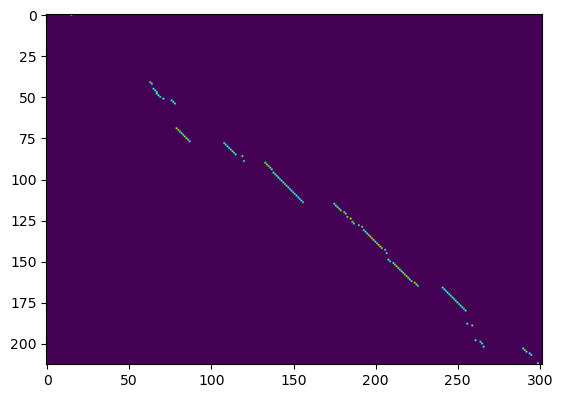

In [116]:
plt.imshow(P)

In [108]:
P = np.zeros_like(S_lol)
p = fb_local(S_lol, -30, -10, 15, np.longdouble)
P[p >= .5] = 1

In [109]:
aligned_seq1, aligned_seq2 = prep_pymol(P)
example_alignment_lol = {'query': query,
                     'target': target,
                     'qstart': 0,
                     'tstart': 0,
                     'taln': aligned_seq1,
                     'qaln': aligned_seq2}
show_aln(pdb_dir='/home/lasse/Desktop/structure_align_project/data/pdbc/', aln=example_alignment_lol)

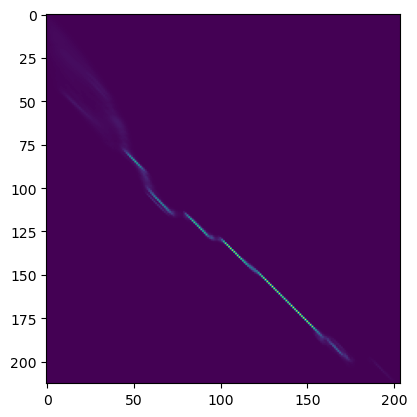

In [110]:
plt.imshow(fb_local(S_lol, -30, -10, 15, np.longdouble))

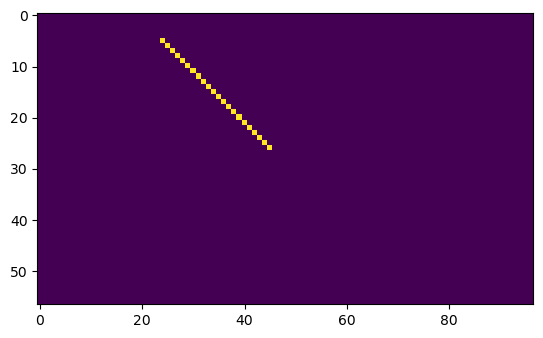

In [64]:
plt.imshow(P)

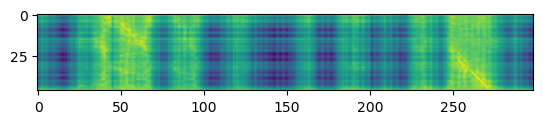

In [731]:
plt.imshow(S_lol)

In [73]:
S_lol[fb_local(S_lol, -30, -10, 15, np.longdouble) < 0.1] = 0

In [75]:
(S_lol*fb_local(S_lol, -30, -10, 15, np.longdouble)).sum()

2525.2194873563730904